# Introduction

The aim of this notebook is to demonstrate the tree-sequence-based linear mixed model, its parameters and related/derived quantities, and underlying vectors and matrices. The emphasis is on "model pedagogy" rather than efficient estimation.

# Setup

In [446]:
import io
import os
import sys
from IPython.display import SVG

import numpy as np
np.set_printoptions(linewidth = 120)
import numba
import scipy.sparse as sparse

import tskit

# TODO: remove sys.path.append after tslmm becomes a package
# sys.path.append(os.getcwd() + "/../")
tsblup_path = "/Users/ggorjanc/Storages/GitBox/tskit/tsblup/tsblup_upstream/"
sys.path.append(tsblup_path)
import tsblup.operations as operations
import tsblup.matrices as matrices

# TODO: remove sys.path.append after ste_draft is merged in
sys.path.append(tsblup_path + "ste_draft")
from linear_operators import TraitCovariance, NystromPreconditioner
from genetic_values import edge_effects as edge_effects_fun

# Generate a tree sequence example

In [447]:
nodes = io.StringIO(
    """\
    id is_sample time individual
     0         1    0          0
     1         1    0          0
     2         1    0          1
     3         1    0          1
     4         0    1         -1
     5         0    1         -1
     6         0    2         -1
     7         0    4         -1
    """
)

edges = io.StringIO(
    """\
    left right parent child
       0    10      4     0
       0     5      4     1
       5    10      5     1
       0    10      5     2
       0    10      6     3
       0    10      6     5
       0    10      7     4
       0    10      7     6
    """
)

individuals = io.StringIO(
    """\
    flags location parents
        0        0      -1
        0        0      -1
    """
)

ts = tskit.load_text(nodes = nodes, edges = edges, individuals = individuals, strict = False)
print(ts)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │        2║
╟───────────────┼─────────╢
║Sequence Length│       10║
╟───────────────┼─────────╢
║Time Units     │  unknown║
╟───────────────┼─────────╢
║Sample Nodes   │        4║
╟───────────────┼─────────╢
║Total Size     │743 Bytes║
╚═══════════════╧═════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │   8│264 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│   2│104 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │   8│232 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Prove

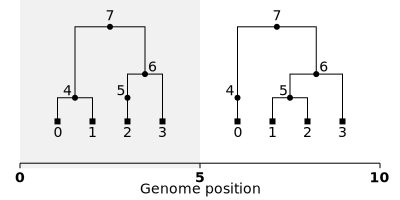

In [448]:
SVG(ts.draw_svg())

# Split-upwards the tree sequence

In [449]:
print(ts.num_edges) # before the split
print(ts.dump_tables().edges)

8
╔══╤════╤═════╤══════╤═════╤════════╗
║id│left│right│parent│child│metadata║
╠══╪════╪═════╪══════╪═════╪════════╣
║0 │   0│   10│     4│    0│        ║
║1 │   0│    5│     4│    1│        ║
║2 │   5│   10│     5│    1│        ║
║3 │   0│   10│     5│    2│        ║
║4 │   0│   10│     6│    3│        ║
║5 │   0│   10│     6│    5│        ║
║6 │   0│   10│     7│    4│        ║
║7 │   0│   10│     7│    6│        ║
╚══╧════╧═════╧══════╧═════╧════════╝

8
╔══╤════╤═════╤══════╤═════╤════════╗
║id│left│right│parent│child│metadata║
╠══╪════╪═════╪══════╪═════╪════════╣
║0 │   0│   10│     4│    0│        ║
║1 │   0│    5│     4│    1│        ║
║2 │   5│   10│     5│    1│        ║
║3 │   0│   10│     5│    2│        ║
║4 │   0│   10│     6│    3│        ║
║5 │   0│   10│     6│    5│        ║
║6 │   0│   10│     7│    4│        ║
║7 │   0│   10│     7│    6│        ║
╚══╧════╧═════╧══════╧═════╧════════╝



In [450]:
ts = operations.split_upwards(ts)

print(ts.num_edges) # after the split
print(ts.dump_tables().edges)

11
╔══╤════╤═════╤══════╤═════╤════════╗
║id│left│right│parent│child│metadata║
╠══╪════╪═════╪══════╪═════╪════════╣
║0 │   0│   10│     4│    0│        ║
║1 │   0│    5│     4│    1│        ║
║2 │   5│   10│     5│    1│        ║
║3 │   0│   10│     5│    2│        ║
║4 │   0│   10│     6│    3│        ║
║5 │   0│    5│     6│    5│        ║
║6 │   5│   10│     6│    5│        ║
║7 │   0│    5│     7│    4│        ║
║8 │   5│   10│     7│    4│        ║
║9 │   0│    5│     7│    6│        ║
║10│   5│   10│     7│    6│        ║
╚══╧════╧═════╧══════╧═════╧════════╝

11
╔══╤════╤═════╤══════╤═════╤════════╗
║id│left│right│parent│child│metadata║
╠══╪════╪═════╪══════╪═════╪════════╣
║0 │   0│   10│     4│    0│        ║
║1 │   0│    5│     4│    1│        ║
║2 │   5│   10│     5│    1│        ║
║3 │   0│   10│     5│    2│        ║
║4 │   0│   10│     6│    3│        ║
║5 │   0│    5│     6│    5│        ║
║6 │   5│   10│     6│    5│        ║
║7 │   0│    5│     7│    4│        ║
║8 │ 

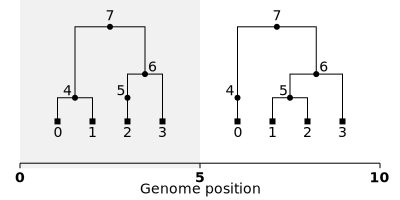

In [451]:
SVG(ts.draw_svg())

# Setup matrices

In [452]:

# TODO: This model notation and assumptions will go into the manuscript

# The assumed model here is:
# 
# y = Xb + Zg + e
# 
# y (n_y * 1) phenotypic values
# X (n_y * n_b) design matrix linking y with b
# b (n_b * 1) fixed effects
# Z (n_y * n_g) design matrix linking y with g
# g (n_g * 1) individuals' genetic values
# e (n_y * 1) residuals; e ~ N(0, I sigma^2_e)
# 
# g = Wr
# W (n_g * n_edges) design matrix linking g with r
# r (n_edges * 1) edge values
# 
# r = Tu
# T (n_edges * n_edges) design matrix linking r with u (summing up u into edge values)
# u (n_edges * 1) edge "innovation" effects on edge areas; u ~ N(0, D sigma^2_u)
# (due to new mutations arising along the DNA span of edges between "parent" and "child"
#  nodes and along the time length of edges --> edge areas)
# 
# r = TSu*; u* ~ N(0, I sigma^2_u)
# T (n_edges * n_edges) edge design matrix linking r with u* (summing up u* into edge values)
# S (n_edges * n_edges) diagonal matrix with sqrt(edge areas)
# u (n_edges * 1) normalised edge "innovation" effects; u* ~ N(0, sigma^2_u)
# 
# n = Nr
# n (n_nodes * 1) node values
# N (n_nodes * n_edges) design matrix linking n with r (summing up r into node values)
# 
# Covariance between edge values (r = Tu = TSu*):
# 
# C_r = Var(r | T, S) = TSS'T' sigma^2_u = TDT' sigma^2_u
#
# Covariance between node values (n = Nr):
# 
# C_n = Var(n | N, T, S) = NTDT'N' sigma^2_u
#
# Covariance between genetic values (g = Wr):
# 
# C_g = Var(g | W, T, S) = WTDT'W' sigma^2_u
#  
# Covariance between phenotypic values (y = Xb + Zg + e):
# 
# C_y = Var(y | Z, W, T, S) = ZWTDT'W'Z' sigma^2_u + I sigma^2_e
# 
# Some relations:
#  
# Q_r = inv(C_r) = inv(TDT' sigma^2_u) = inv(LL' sigma^2_u)
#     = inv(T)' inv(D) inv(T) sigma^(-2)_u = inv(L)' inv(L) sigma^(-2)_u
#     = (I - E)' inv(D) (I - E) sigma^(-2)_u
#     = (I - E)' inv(SS) (I - E) sigma^(-2)_u
# inv(L) = inv(S) (I - E) = inv(S) inv(T)
# L = inv(inv(L)) = inv(inv(S) inv(T)) = TS
# inv(T) = I - E

# Design matrix linking design matrix linking y with b
X = np.array([1, 1])

# Design matrix linking individuals and edges (those that point to individuals' nodes)
# (at the moment, W matrix here combines Z & W matrices above)
W = matrices.edge_individual_matrix(ts).T
print(W.shape)
print(W)

(2, 11)
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 3)	1.0
  (1, 4)	1.0
(2, 11)
  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (1, 3)	1.0
  (1, 4)	1.0


In [453]:
# Edge value "structure" matrix (TInv = I-E) (adjacent edges)
TInv = sparse.identity(ts.num_edges) - matrices.edge_adjacency(ts).T
TInv.sort_indices() # ensure order for working across Python packages
print(TInv.shape)
print(TInv.toarray()) # it's upper-triangular because we order/number edges back in time

(11, 11)
[[ 1.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(11, 11)
[[ 1.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0. -1. -1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.

In [454]:
# Edge value design matrix (T = inv(I-E)) (edge connections back in time)
T = np.linalg.inv(TInv.toarray())
print(T) # it's upper-triangular because we order/number edges back in time

[[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [455]:
# Diagonal matrix of variance or precision coefficients of edge effects
edge_spans = ts.edges_right - ts.edges_left
edge_lengths = ts.nodes_time[ts.edges_parent] - ts.nodes_time[ts.edges_child]
edge_areas = edge_spans * edge_lengths # = mutational_target
D = sparse.diags_array(edge_areas)
S = np.sqrt(D)
DInv = sparse.diags_array(1 / edge_areas)
SInv = np.sqrt(DInv)
print(np.column_stack((edge_spans, edge_lengths, edge_areas, (1 / edge_areas).round(3))))

[[10.     1.    10.     0.1  ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     1.     5.     0.2  ]
 [10.     1.    10.     0.1  ]
 [10.     2.    20.     0.05 ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     3.    15.     0.067]
 [ 5.     3.    15.     0.067]
 [ 5.     2.    10.     0.1  ]
 [ 5.     2.    10.     0.1  ]]
[[10.     1.    10.     0.1  ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     1.     5.     0.2  ]
 [10.     1.    10.     0.1  ]
 [10.     2.    20.     0.05 ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     1.     5.     0.2  ]
 [ 5.     3.    15.     0.067]
 [ 5.     3.    15.     0.067]
 [ 5.     2.    10.     0.1  ]
 [ 5.     2.    10.     0.1  ]]


In [456]:
# Precision coefficient matrix for edge effects per unit area
Qus = sparse.identity(ts.num_edges)
print(Qus.toarray().round(3))
# See below for print((Qus.toarray() / sigma2u).round(3))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [457]:
# Covariance coefficient matrix for edge effects per unit area
Cus = sparse.identity(ts.num_edges).toarray()
print(Cus.round(3))
# See below for print((Qu / sigma2u).round(3))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [458]:
# Precision coefficient matrix for edge effects
Qu = DInv
print(Qu.toarray().round(3))
# See below for print((Qu.toarray() / sigma2u).round(3))

[[0.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.2   0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.2   0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.1   0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.05  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.2   0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.2   0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.067 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.067 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1   0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.1  ]]
[[0.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.2   0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.2   0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.1   0.    0

In [459]:
# Covariance coefficient matrix for edge effects
Cu = np.linalg.inv(Qu.toarray())
print(Cu.round(3))
# See below for print((Qu / sigma2u).round(3))

[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]]
[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  5.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0

In [460]:
# Cholesky factor of precision coefficient matrix for edge values
LInv = SInv @ TInv
print(LInv.toarray().round(3))

[[ 0.316  0.     0.     0.     0.     0.     0.    -0.316 -0.316  0.     0.   ]
 [ 0.     0.447  0.     0.     0.     0.     0.    -0.447  0.     0.     0.   ]
 [ 0.     0.     0.447  0.     0.     0.    -0.447  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.316  0.    -0.316 -0.316  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.224  0.     0.     0.     0.    -0.224 -0.224]
 [ 0.     0.     0.     0.     0.     0.447  0.     0.     0.    -0.447  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.447  0.     0.     0.    -0.447]
 [ 0.     0.     0.     0.     0.     0.     0.     0.258  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.258  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.316  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.316]]
[[ 0.316  0.     0.     0.     0.     0.     0.    -0.316 -0.316  0.     0.   ]
 [ 0.     0.447  0.     0.     0.     0

In [461]:
# Cholesky factor of covariance coefficient matrix for edge values
L = np.linalg.inv(LInv.toarray())
print(L.round(3))
# print((T @ S).round(3))

[[3.162 0.    0.    0.    0.    0.    0.    3.873 3.873 0.    0.   ]
 [0.    2.236 0.    0.    0.    0.    0.    3.873 0.    0.    0.   ]
 [0.    0.    2.236 0.    0.    0.    2.236 0.    0.    0.    3.162]
 [0.    0.    0.    3.162 0.    2.236 2.236 0.    0.    3.162 3.162]
 [0.    0.    0.    0.    4.472 0.    0.    0.    0.    3.162 3.162]
 [0.    0.    0.    0.    0.    2.236 0.    0.    0.    3.162 0.   ]
 [0.    0.    0.    0.    0.    0.    2.236 0.    0.    0.    3.162]
 [0.    0.    0.    0.    0.    0.    0.    3.873 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    3.873 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    3.162 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    3.162]]
[[3.162 0.    0.    0.    0.    0.    0.    3.873 3.873 0.    0.   ]
 [0.    2.236 0.    0.    0.    0.    0.    3.873 0.    0.    0.   ]
 [0.    0.    2.236 0.    0.    0.    2.236 0.    0.    0.    3.162]
 [0.    0.    0.    3.162 0.    2

In [462]:
# Precision coefficient matrix for edge values
Qr = LInv.T @ LInv
print(Qr.toarray().round(3))
# See below for print((Qr.toarray() / sigma2u).round(3))

[[ 0.1    0.     0.     0.     0.     0.     0.    -0.1   -0.1    0.     0.   ]
 [ 0.     0.2    0.     0.     0.     0.     0.    -0.2    0.     0.     0.   ]
 [ 0.     0.     0.2    0.     0.     0.    -0.2    0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.1    0.    -0.1   -0.1    0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.05   0.     0.     0.     0.    -0.05  -0.05 ]
 [ 0.     0.     0.    -0.1    0.     0.3    0.1    0.     0.    -0.2    0.   ]
 [ 0.     0.    -0.2   -0.1    0.     0.1    0.5    0.     0.     0.    -0.2  ]
 [-0.1   -0.2    0.     0.     0.     0.     0.     0.367  0.1    0.     0.   ]
 [-0.1    0.     0.     0.     0.     0.     0.     0.1    0.167  0.     0.   ]
 [ 0.     0.     0.     0.    -0.05  -0.2    0.     0.     0.     0.35   0.05 ]
 [ 0.     0.     0.     0.    -0.05   0.    -0.2    0.     0.     0.05   0.35 ]]
[[ 0.1    0.     0.     0.     0.     0.     0.    -0.1   -0.1    0.     0.   ]
 [ 0.     0.2    0.     0.     0.     0

In [463]:
# Covariance coefficient matrix for edge values
Cr = L @ L.T
print(Cr.round(3))
print("Check")
Cr = np.linalg.inv(Qr.toarray())
print(Cr.round(3))
# See below for print((Cr / sigma2u).round(3))

[[40. 15.  0.  0.  0.  0.  0. 15. 15.  0.  0.]
 [15. 20.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [ 0.  0. 20. 15. 10.  0. 15.  0.  0.  0. 10.]
 [ 0.  0. 15. 40. 20. 15. 15.  0.  0. 10. 10.]
 [ 0.  0. 10. 20. 40. 10. 10.  0.  0. 10. 10.]
 [ 0.  0.  0. 15. 10. 15.  0.  0.  0. 10.  0.]
 [ 0.  0. 15. 15. 10.  0. 15.  0.  0.  0. 10.]
 [15. 15.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [15.  0.  0.  0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0.  0. 10. 10. 10.  0.  0.  0. 10.  0.]
 [ 0.  0. 10. 10. 10.  0. 10.  0.  0.  0. 10.]]
Check
[[40. 15.  0.  0.  0.  0.  0. 15. 15.  0.  0.]
 [15. 20.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [ 0.  0. 20. 15. 10. -0. 15.  0.  0. -0. 10.]
 [ 0.  0. 15. 40. 20. 15. 15.  0.  0. 10. 10.]
 [ 0.  0. 10. 20. 40. 10. 10.  0.  0. 10. 10.]
 [ 0.  0. -0. 15. 10. 15. -0.  0.  0. 10. -0.]
 [ 0.  0. 15. 15. 10. -0. 15.  0.  0. -0. 10.]
 [15. 15.  0.  0.  0.  0.  0. 15.  0.  0.  0.]
 [15.  0.  0.  0.  0.  0.  0.  0. 15.  0.  0.]
 [ 0.  0. -0. 10. 10. 10. -0.  0.  0. 10. -0.]
 [ 0. 

In [464]:
# Covariance coefficient matrix for node values
print("Node-edge design matrix")
N = matrices.edge_child_matrix(ts).T
print(N)

print("Covariance coefficient matrix for node values")
Cn = N @ Cr @ N.T
print(Cn.round(3))
# See below for print((Cn * sigma2u).round(3))
# The last row and column are full of 0s because the last node is the root

Node-edge design matrix
  (0, 0)	1.0
  (1, 1)	1.0
  (1, 2)	1.0
  (2, 3)	1.0
  (3, 4)	1.0
  (5, 5)	1.0
  (5, 6)	1.0
  (4, 7)	1.0
  (4, 8)	1.0
  (6, 9)	1.0
  (6, 10)	1.0
Covariance coefficient matrix for node values
[[40. 15.  0.  0. 30.  0.  0.  0.]
 [15. 40. 15. 10. 15. 15. 10.  0.]
 [ 0. 15. 40. 20.  0. 30. 20.  0.]
 [ 0. 10. 20. 40.  0. 20. 20.  0.]
 [30. 15.  0.  0. 30.  0.  0.  0.]
 [ 0. 15. 30. 20.  0. 30. 20.  0.]
 [ 0. 10. 20. 20.  0. 20. 20.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
Node-edge design matrix
  (0, 0)	1.0
  (1, 1)	1.0
  (1, 2)	1.0
  (2, 3)	1.0
  (3, 4)	1.0
  (5, 5)	1.0
  (5, 6)	1.0
  (4, 7)	1.0
  (4, 8)	1.0
  (6, 9)	1.0
  (6, 10)	1.0
Covariance coefficient matrix for node values
[[40. 15.  0.  0. 30.  0.  0.  0.]
 [15. 40. 15. 10. 15. 15. 10.  0.]
 [ 0. 15. 40. 20.  0. 30. 20.  0.]
 [ 0. 10. 20. 40.  0. 20. 20.  0.]
 [30. 15.  0.  0. 30.  0.  0.  0.]
 [ 0. 15. 30. 20.  0. 30. 20.  0.]
 [ 0. 10. 20. 20.  0. 20. 20.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


In [465]:
# Precision coefficient matrix for node values
Qn = np.linalg.inv(Cn[0:(ts.num_nodes - 1), 0:(ts.num_nodes - 1)])
print(Qn.round(3))
# See below for print((Qn / sigma2u).round(3))

[[ 0.1   -0.     0.    -0.    -0.1    0.     0.   ]
 [-0.     0.04  -0.     0.    -0.02  -0.02   0.   ]
 [-0.    -0.     0.1    0.     0.    -0.1   -0.   ]
 [-0.     0.    -0.     0.05  -0.     0.    -0.05 ]
 [-0.1   -0.02  -0.    -0.     0.143  0.01  -0.   ]
 [-0.    -0.02  -0.1   -0.     0.01   0.21  -0.1  ]
 [ 0.     0.    -0.    -0.05   0.    -0.1    0.2  ]]
[[ 0.1   -0.     0.    -0.    -0.1    0.     0.   ]
 [-0.     0.04  -0.     0.    -0.02  -0.02   0.   ]
 [-0.    -0.     0.1    0.     0.    -0.1   -0.   ]
 [-0.     0.    -0.     0.05  -0.     0.    -0.05 ]
 [-0.1   -0.02  -0.    -0.     0.143  0.01  -0.   ]
 [-0.    -0.02  -0.1   -0.     0.01   0.21  -0.1  ]
 [ 0.     0.    -0.    -0.05   0.    -0.1    0.2  ]]


In [466]:
# Covariance coefficient matrix for genetic values
Cg = W @ Cr @ W.T
print(Cg.round(3))
# See below for print((Cg * sigma2u).round(3))

[[110.  25.]
 [ 25. 120.]]
[[110.  25.]
 [ 25. 120.]]


In [467]:
# Precision coefficient matrix for genetic values
Qg = np.linalg.inv(Cg)
print(Qg.round(3))
# See below for print((Qg / sigma2u).round(3))

[[ 0.01  -0.002]
 [-0.002  0.009]]
[[ 0.01  -0.002]
 [-0.002  0.009]]


In [468]:
# Covariance and precision coefficient matrices multipled by sigma2u

sigma2u = 0.001

print("Cus - covariance matrix for edge effects per unit area")
print((Cus * sigma2u).round(3))
print("Qus - precision matrix for edge effects per unit area")
print((Qus.toarray() / sigma2u).round(3))

Cus - covariance matrix for edge effects per unit area
[[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001]]
Qus - precision matrix for edge effects per unit area
[[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.    0.    0. 

In [469]:

print("Cu - covariance matrix for edge effects")
print((Cu * sigma2u).round(3))
print("Qu - precision matrix for edge effects")
print((Qu.toarray() / sigma2u).round(3))

Cu - covariance matrix for edge effects
[[0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.005 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.005 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.02  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.005 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.005 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.015 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.015 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01 ]]
Qu - precision matrix for edge effects
[[100.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.   ]
 [  0.    200.      0.      0.      0.      0.      0.      0.      0.

In [470]:
print("Cr - covariance matrix for edge values")
print((Cr * sigma2u).round(3))
print("Qr - precision matrix for edge values")
print((Qr.toarray() / sigma2u).round(3))

Cr - covariance matrix for edge values
[[ 0.04   0.015  0.     0.     0.     0.     0.     0.015  0.015  0.     0.   ]
 [ 0.015  0.02   0.     0.     0.     0.     0.     0.015  0.     0.     0.   ]
 [ 0.     0.     0.02   0.015  0.01  -0.     0.015  0.     0.    -0.     0.01 ]
 [ 0.     0.     0.015  0.04   0.02   0.015  0.015  0.     0.     0.01   0.01 ]
 [ 0.     0.     0.01   0.02   0.04   0.01   0.01   0.     0.     0.01   0.01 ]
 [ 0.     0.    -0.     0.015  0.01   0.015 -0.     0.     0.     0.01  -0.   ]
 [ 0.     0.     0.015  0.015  0.01  -0.     0.015  0.     0.    -0.     0.01 ]
 [ 0.015  0.015  0.     0.     0.     0.     0.     0.015  0.     0.     0.   ]
 [ 0.015  0.     0.     0.     0.     0.     0.     0.     0.015  0.     0.   ]
 [ 0.     0.    -0.     0.01   0.01   0.01  -0.     0.     0.     0.01  -0.   ]
 [ 0.     0.     0.01   0.01   0.01  -0.     0.01   0.     0.    -0.     0.01 ]]
Qr - precision matrix for edge values
[[ 100.       0.       0.       0.       0

In [471]:
print("Cr - covariance matrix for node values")
print((Cn * sigma2u).round(3))
print("Qr - precision matrix for node values")
print((Qn / sigma2u).round(3))

Cr - covariance matrix for node values
[[0.04  0.015 0.    0.    0.03  0.    0.    0.   ]
 [0.015 0.04  0.015 0.01  0.015 0.015 0.01  0.   ]
 [0.    0.015 0.04  0.02  0.    0.03  0.02  0.   ]
 [0.    0.01  0.02  0.04  0.    0.02  0.02  0.   ]
 [0.03  0.015 0.    0.    0.03  0.    0.    0.   ]
 [0.    0.015 0.03  0.02  0.    0.03  0.02  0.   ]
 [0.    0.01  0.02  0.02  0.    0.02  0.02  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]
Qr - precision matrix for node values
[[ 100.      -0.       0.      -0.    -100.       0.       0.   ]
 [  -0.      40.      -0.       0.     -20.     -20.       0.   ]
 [  -0.      -0.     100.       0.       0.    -100.      -0.   ]
 [  -0.       0.      -0.      50.      -0.       0.     -50.   ]
 [-100.     -20.      -0.      -0.     143.333   10.      -0.   ]
 [  -0.     -20.    -100.      -0.      10.     210.    -100.   ]
 [   0.       0.      -0.     -50.       0.    -100.     200.   ]]
Cr - covariance matrix for node values
[[0.04  0.01

In [472]:
print("Cr - covariance matrix for genetic values")
print((Cg * sigma2u).round(3))
print("Qr - precision matrix for genetic values")
print((Qg / sigma2u).round(3))

Cr - covariance matrix for genetic values
[[0.11  0.025]
 [0.025 0.12 ]]
Qr - precision matrix for genetic values
[[ 9.543 -1.988]
 [-1.988  8.748]]
Cr - covariance matrix for genetic values
[[0.11  0.025]
 [0.025 0.12 ]]
Qr - precision matrix for genetic values
[[ 9.543 -1.988]
 [-1.988  8.748]]


# Simulate values

In [473]:

edge_effects = np.random.normal(size = ts.num_edges,
                                scale = np.sqrt(edge_areas * sigma2u)).round(3)
# For this pedagogical demonstration we use large & simple values for edge effects
# (you can swap with the above sampled edge effects instead)
#                        0,  1, 2, 3, 4, 5,  6, 7,  8, 9, 10
edge_effects = np.array([0, -1, 1, 0, 2, 0, -1, 2, -1, 0, -1])
print(edge_effects) # u 

[ 0 -1  1  0  2  0 -1  2 -1  0 -1]
[ 0 -1  1  0  2  0 -1  2 -1  0 -1]


In [474]:
edge_effects_per_unit_area = edge_effects / np.sqrt(edge_areas)
print(edge_effects_per_unit_area) # u*

[ 0.         -0.4472136   0.4472136   0.          0.4472136   0.         -0.4472136   0.51639778 -0.25819889
  0.         -0.31622777]
[ 0.         -0.4472136   0.4472136   0.          0.4472136   0.         -0.4472136   0.51639778 -0.25819889
  0.         -0.31622777]


In [475]:
edge_values = T @ edge_effects # r = Tu
print(edge_values)

[ 1.  1. -1. -2.  1.  0. -2.  2. -1.  0. -1.]
[ 1.  1. -1. -2.  1.  0. -2.  2. -1.  0. -1.]


In [476]:
node_values = N @ edge_values # n = Nr = NTu
print(node_values)

[ 1.  0. -2.  1.  1. -2. -1.  0.]
[ 1.  0. -2.  1.  1. -2. -1.  0.]


In [477]:
genetic_values = W @ edge_values # g = Wr = WTu (via edge values - canonical approach)
print(genetic_values)

[ 1. -1.]
[ 1. -1.]


In [478]:
M = matrices.node_individual_matrix(ts).T
print("Node-individual design matrix")
print(M)
print("Genetic values")
genetic_values2 = M @ node_values # g = Mn = MNr = MNTu (via node values)
print(np.column_stack((genetic_values, genetic_values2)))


Node-individual design matrix
  (0, 0)	1.0
  (0, 1)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
Genetic values
[[ 1.  1.]
 [-1. -1.]]
Node-individual design matrix
  (0, 0)	1.0
  (0, 1)	1.0
  (1, 2)	1.0
  (1, 3)	1.0
Genetic values
[[ 1.  1.]
 [-1. -1.]]


In [479]:
sigma2e = 1
residuals = np.random.normal(size = ts.num_individuals,
                             scale = np.sqrt(sigma2e)).round()
# For this pedagogical demonstration we use small & simple values for residuals
# (you can swap with the above sampled residuals instead)
#                       0,    1
residuals = np.array([0.1, -0.1])
print(residuals)

[ 0.1 -0.1]
[ 0.1 -0.1]


In [480]:
intercept = 10
phenotype_values = intercept + genetic_values + residuals
print(phenotype_values)

[11.1  8.9]
[11.1  8.9]


# Estimate effects and values (using simple pedagogic approach)

Throughout we assume we know variance components!

In [481]:
# Phenotypic variance matrix
Cy = Cg * sigma2u + np.eye(N = len(phenotype_values)) * sigma2e
print(Cy)

[[1.11  0.025]
 [0.025 1.12 ]]
[[1.11  0.025]
 [0.025 1.12 ]]


In [482]:
# Phenotypic precision matrix
Qy = np.linalg.inv(Cy)
print(Qy)

[[ 0.90135404 -0.02011951]
 [-0.02011951  0.89330624]]
[[ 0.90135404 -0.02011951]
 [-0.02011951  0.89330624]]


In [483]:
# Best linear estimate of intercept
intercept_hat = (X.T @ phenotype_values) / (X.T @ X)
print(np.column_stack((intercept, intercept_hat)))

[[10. 10.]]
[[10. 10.]]


In [484]:
# Best linear prediction of genetic values (g)
# cov(g, (y = g + e)') inv(var(y)) (y - E(y))
tmp = (np.linalg.inv(Cy) @ (phenotype_values - intercept_hat))
# cov(g, g') ...
genetic_values_hat = (Cg * sigma2u) @ tmp
print(np.column_stack((genetic_values, genetic_values_hat)))

[[ 1.          0.08637909]
 [-1.         -0.09523168]]
[[ 1.          0.08637909]
 [-1.         -0.09523168]]


In [485]:
# Best linear prediction of node values (n; g = Mn = MNr)
# cov(n, (y = g + e)') inv(var(y)) (y - E(y))
# cov(n, g' = nM') ...
node_values_hat = (Cn @ M.T * sigma2u) @ tmp
print(np.column_stack((node_values, node_values_hat)))

[[ 1.          0.05574915]
 [ 0.          0.03062994]
 [-2.         -0.04508179]
 [ 1.         -0.05014989]
 [ 1.          0.04561294]
 [-2.         -0.0350341 ]
 [-1.         -0.03005452]
 [ 0.          0.        ]]
[[ 1.          0.05574915]
 [ 0.          0.03062994]
 [-2.         -0.04508179]
 [ 1.         -0.05014989]
 [ 1.          0.04561294]
 [-2.         -0.0350341 ]
 [-1.         -0.03005452]
 [ 0.          0.        ]]


In [486]:
# Best linear prediction of edge values (r; g = Wr)
# cov(r, (y = g + e)') inv(var(y)) (y - E(y))
# cov(r, g' = rW') ...
edge_values_hat = (Cr @ W.T * sigma2u) @ tmp
print(np.column_stack((edge_values, edge_values_hat)))

[[ 1.          0.05574915]
 [ 1.          0.03547673]
 [-1.         -0.00484679]
 [-2.         -0.04508179]
 [ 1.         -0.05014989]
 [ 0.         -0.02511921]
 [-2.         -0.00991489]
 [ 2.          0.03040863]
 [-1.          0.01520431]
 [ 0.         -0.02009537]
 [-1.         -0.00995916]]
[[ 1.          0.05574915]
 [ 1.          0.03547673]
 [-1.         -0.00484679]
 [-2.         -0.04508179]
 [ 1.         -0.05014989]
 [ 0.         -0.02511921]
 [-2.         -0.00991489]
 [ 2.          0.03040863]
 [-1.          0.01520431]
 [ 0.         -0.02009537]
 [-1.         -0.00995916]]


In [487]:
# Best linear prediction of edge effects (u; g = WTu)
# cov(u, (y = g + e)') inv(var(y)) (y - E(y))
# cov(u, g' = uT'W') ...
edge_effects_hat = (Cu @ T.T @ W.T * sigma2u) @ tmp
print(np.column_stack((edge_effects, edge_effects_hat)))

[[ 0.00000000e+00  1.01362091e-02]
 [-1.00000000e+00  5.06810454e-03]
 [ 1.00000000e+00  5.06810454e-03]
 [ 0.00000000e+00 -1.00476832e-02]
 [ 2.00000000e+00 -2.00953665e-02]
 [ 0.00000000e+00 -5.02384162e-03]
 [-1.00000000e+00  4.42629218e-05]
 [ 2.00000000e+00  3.04086272e-02]
 [-1.00000000e+00  1.52043136e-02]
 [ 0.00000000e+00 -2.00953665e-02]
 [-1.00000000e+00 -9.95915739e-03]]
[[ 0.00000000e+00  1.01362091e-02]
 [-1.00000000e+00  5.06810454e-03]
 [ 1.00000000e+00  5.06810454e-03]
 [ 0.00000000e+00 -1.00476832e-02]
 [ 2.00000000e+00 -2.00953665e-02]
 [ 0.00000000e+00 -5.02384162e-03]
 [-1.00000000e+00  4.42629218e-05]
 [ 2.00000000e+00  3.04086272e-02]
 [-1.00000000e+00  1.52043136e-02]
 [ 0.00000000e+00 -2.00953665e-02]
 [-1.00000000e+00 -9.95915739e-03]]


In [488]:
# Best linear prediction of edge effects per unit area (u*; u = Su*)
edge_effects_per_unit_area_hat = edge_effects_hat / np.sqrt(edge_areas)
print(np.column_stack((edge_effects_per_unit_area, edge_effects_per_unit_area_hat)))

[[ 0.00000000e+00  3.20535075e-03]
 [-4.47213595e-01  2.26652525e-03]
 [ 4.47213595e-01  2.26652525e-03]
 [ 0.00000000e+00 -3.17735642e-03]
 [ 4.47213595e-01 -4.49346055e-03]
 [ 0.00000000e+00 -2.24673027e-03]
 [-4.47213595e-01  1.97949804e-05]
 [ 5.16397779e-01  7.85147379e-03]
 [-2.58198890e-01  3.92573690e-03]
 [ 0.00000000e+00 -6.35471285e-03]
 [-3.16227766e-01 -3.14936209e-03]]
[[ 0.00000000e+00  3.20535075e-03]
 [-4.47213595e-01  2.26652525e-03]
 [ 4.47213595e-01  2.26652525e-03]
 [ 0.00000000e+00 -3.17735642e-03]
 [ 4.47213595e-01 -4.49346055e-03]
 [ 0.00000000e+00 -2.24673027e-03]
 [-4.47213595e-01  1.97949804e-05]
 [ 5.16397779e-01  7.85147379e-03]
 [-2.58198890e-01  3.92573690e-03]
 [ 0.00000000e+00 -6.35471285e-03]
 [-3.16227766e-01 -3.14936209e-03]]


In [489]:
# Repeating the above via the system of equations for the linear mixed model

# TODO: why do we have differences in estimates? numerical or code errors?

XX = np.array(X.T @ X, ndmin = 2)
XW = np.array(X.T @ W, ndmin = 2)
WX = XW.T
WW = (W.T @ W).toarray() + Qr * sigma2e / sigma2u
LHS = np.concatenate((np.concatenate((XX, XW), axis = 1),
                      np.concatenate((WX, WW), axis = 1)),
                     axis = 0)

Xy = np.array(X.T @ phenotype_values, ndmin = 2)
Wy = np.array(W.T @ phenotype_values, ndmin = 2).T
RHS = np.concatenate((Xy, Wy), axis = 0)

solutions_hat = np.linalg.solve(a = LHS, b = RHS)

In [490]:
intercept_hat2 = solutions_hat[0]
print(np.column_stack((intercept, intercept_hat, intercept_hat2)))

[[10.         10.         10.00504587]]
[[10.         10.         10.00504587]]


In [491]:
edge_values_hat2 = solutions_hat[1:12]
print(np.column_stack((edge_values, edge_values_hat, edge_values_hat2)))

[[ 1.          0.05574915  0.05550459]
 [ 1.          0.03547673  0.0353211 ]
 [-1.         -0.00484679 -0.00504587]
 [-2.         -0.04508179 -0.04541284]
 [ 1.         -0.05014989 -0.05045872]
 [ 0.         -0.02511921 -0.02522936]
 [-2.         -0.00991489 -0.01009174]
 [ 2.          0.03040863  0.03027523]
 [-1.          0.01520431  0.01513761]
 [ 0.         -0.02009537 -0.02018349]
 [-1.         -0.00995916 -0.01009174]]
[[ 1.          0.05574915  0.05550459]
 [ 1.          0.03547673  0.0353211 ]
 [-1.         -0.00484679 -0.00504587]
 [-2.         -0.04508179 -0.04541284]
 [ 1.         -0.05014989 -0.05045872]
 [ 0.         -0.02511921 -0.02522936]
 [-2.         -0.00991489 -0.01009174]
 [ 2.          0.03040863  0.03027523]
 [-1.          0.01520431  0.01513761]
 [ 0.         -0.02009537 -0.02018349]
 [-1.         -0.00995916 -0.01009174]]


In [492]:
edge_effects_hat2 = TInv @ edge_values_hat2 # r = Tu --> inv(T) r = u
print(np.column_stack((edge_effects, edge_effects_hat, edge_effects_hat2)))

[[ 0.00000000e+00  1.01362091e-02  1.00917431e-02]
 [-1.00000000e+00  5.06810454e-03  5.04587156e-03]
 [ 1.00000000e+00  5.06810454e-03  5.04587156e-03]
 [ 0.00000000e+00 -1.00476832e-02 -1.00917431e-02]
 [ 2.00000000e+00 -2.00953665e-02 -2.01834862e-02]
 [ 0.00000000e+00 -5.02384162e-03 -5.04587156e-03]
 [-1.00000000e+00  4.42629218e-05  5.20417043e-18]
 [ 2.00000000e+00  3.04086272e-02  3.02752294e-02]
 [-1.00000000e+00  1.52043136e-02  1.51376147e-02]
 [ 0.00000000e+00 -2.00953665e-02 -2.01834862e-02]
 [-1.00000000e+00 -9.95915739e-03 -1.00917431e-02]]
[[ 0.00000000e+00  1.01362091e-02  1.00917431e-02]
 [-1.00000000e+00  5.06810454e-03  5.04587156e-03]
 [ 1.00000000e+00  5.06810454e-03  5.04587156e-03]
 [ 0.00000000e+00 -1.00476832e-02 -1.00917431e-02]
 [ 2.00000000e+00 -2.00953665e-02 -2.01834862e-02]
 [ 0.00000000e+00 -5.02384162e-03 -5.04587156e-03]
 [-1.00000000e+00  4.42629218e-05  5.20417043e-18]
 [ 2.00000000e+00  3.04086272e-02  3.02752294e-02]
 [-1.00000000e+00  1.52043136e

In [493]:
edge_effects_per_unit_area_hat2 = LInv @ edge_values_hat2 # r = TSu* = Lu* --> inv(L) r = u*
print(np.column_stack((edge_effects_per_unit_area, edge_effects_per_unit_area_hat, edge_effects_per_unit_area_hat2)))

[[ 0.00000000e+00  3.20535075e-03  3.19128938e-03]
 [-4.47213595e-01  2.26652525e-03  2.25658236e-03]
 [ 4.47213595e-01  2.26652525e-03  2.25658236e-03]
 [ 0.00000000e+00 -3.17735642e-03 -3.19128938e-03]
 [ 4.47213595e-01 -4.49346055e-03 -4.51316473e-03]
 [ 0.00000000e+00 -2.24673027e-03 -2.25658236e-03]
 [-4.47213595e-01  1.97949804e-05  2.60208521e-18]
 [ 5.16397779e-01  7.85147379e-03  7.81703061e-03]
 [-2.58198890e-01  3.92573690e-03  3.90851530e-03]
 [ 0.00000000e+00 -6.35471285e-03 -6.38257876e-03]
 [-3.16227766e-01 -3.14936209e-03 -3.19128938e-03]]
[[ 0.00000000e+00  3.20535075e-03  3.19128938e-03]
 [-4.47213595e-01  2.26652525e-03  2.25658236e-03]
 [ 4.47213595e-01  2.26652525e-03  2.25658236e-03]
 [ 0.00000000e+00 -3.17735642e-03 -3.19128938e-03]
 [ 4.47213595e-01 -4.49346055e-03 -4.51316473e-03]
 [ 0.00000000e+00 -2.24673027e-03 -2.25658236e-03]
 [-4.47213595e-01  1.97949804e-05  2.60208521e-18]
 [ 5.16397779e-01  7.85147379e-03  7.81703061e-03]
 [-2.58198890e-01  3.92573690e

In [494]:
node_values_hat2 = N @ edge_values_hat2 # n = Nr
print(np.column_stack((node_values, node_values_hat, node_values_hat2)))

[[ 1.          0.05574915  0.05550459]
 [ 0.          0.03062994  0.03027523]
 [-2.         -0.04508179 -0.04541284]
 [ 1.         -0.05014989 -0.05045872]
 [ 1.          0.04561294  0.04541284]
 [-2.         -0.0350341  -0.0353211 ]
 [-1.         -0.03005452 -0.03027523]
 [ 0.          0.          0.        ]]
[[ 1.          0.05574915  0.05550459]
 [ 0.          0.03062994  0.03027523]
 [-2.         -0.04508179 -0.04541284]
 [ 1.         -0.05014989 -0.05045872]
 [ 1.          0.04561294  0.04541284]
 [-2.         -0.0350341  -0.0353211 ]
 [-1.         -0.03005452 -0.03027523]
 [ 0.          0.          0.        ]]


In [495]:
genetic_values_hat2 = W @ edge_values_hat2 # g = Wr
print(np.column_stack((genetic_values, genetic_values_hat, genetic_values_hat2)))

[[ 1.          0.08637909  0.08577982]
 [-1.         -0.09523168 -0.09587156]]
[[ 1.          0.08637909  0.08577982]
 [-1.         -0.09523168 -0.09587156]]


# Estimate effects and values (using tslmm)

In [496]:
y = phenotype_values - intercept_hat

covmat = TraitCovariance(ts)
precon = NystromPreconditioner(covmat, rank = 1, samples = 10)
edge_effects_per_unit_area_cg_hat, _ = edge_effects_fun(sigma2e, sigma2u, y, covmat, None)
Xn = covmat.Z.toarray() @ np.linalg.inv(covmat.L.T.toarray())
post_var = np.linalg.inv(np.eye(covmat.factor_dim) / sigma2u + Xn.T @ Xn / sigma2e)
edge_effects_per_unit_area_exact_hat = post_var @ Xn.T @ y / sigma2e

print(np.column_stack((edge_effects_per_unit_area, edge_effects_per_unit_area_hat,
                       edge_effects_per_unit_area_exact_hat, edge_effects_per_unit_area_cg_hat)))

2
[[ 0.00000000e+00  3.20535075e-03  3.20535075e-03  3.20535075e-03]
 [-4.47213595e-01  2.26652525e-03  2.26652525e-03  2.26652525e-03]
 [ 4.47213595e-01  2.26652525e-03  2.26652525e-03  2.26652525e-03]
 [ 0.00000000e+00 -3.17735642e-03 -3.17735642e-03 -3.17735642e-03]
 [ 4.47213595e-01 -4.49346055e-03 -4.49346055e-03 -4.49346055e-03]
 [ 0.00000000e+00 -2.24673027e-03 -2.24673027e-03 -2.24673027e-03]
 [-4.47213595e-01  1.97949804e-05  1.97949804e-05  1.97949804e-05]
 [ 5.16397779e-01  7.85147379e-03  7.85147379e-03  7.85147379e-03]
 [-2.58198890e-01  3.92573690e-03  3.92573690e-03  3.92573690e-03]
 [ 0.00000000e+00 -6.35471285e-03 -6.35471285e-03 -6.35471285e-03]
 [-3.16227766e-01 -3.14936209e-03 -3.14936209e-03 -3.14936209e-03]]
2
[[ 0.00000000e+00  3.20535075e-03  3.20535075e-03  3.20535075e-03]
 [-4.47213595e-01  2.26652525e-03  2.26652525e-03  2.26652525e-03]
 [ 4.47213595e-01  2.26652525e-03  2.26652525e-03  2.26652525e-03]
 [ 0.00000000e+00 -3.17735642e-03 -3.17735642e-03 -3.1773